# Cancer Classification using Microarray Data
Alex Janss

## Introduction
The GEO database is home to thousands of microarray datasets. These datasets measure the relative gene expression across thousands of selected genes for a given patient sample. Each value in the output roughly corresponds to the abundance of an RNA molecule of a given type (corresponding to the given gene) for a particular sample, with higher values indicating more RNA molecules. 

Microarrays are an extremely important source of data, as they are very cheap and easy to run and yeild lots of information about the state of the cells from the sample. The gene expression data obtained form the cells yeilds information about the cells' activity and can be used to distinguish types of cells (eg. brain vs liver) and states of cells (eg. healthy vs diseased).

The dataset used in this experiment has 174 different samples, each from one of nine different types of cancer (Breast, Central Nervous System, Colon, Leukemia, Melanoma, Non-Small Cell Lung, Ovarian, Prostate, and Renal). My goal is to create a model that will be able to sucessfuly classify a sample into one of the 9 cancer type by the microarray expression data. I will be using **Naive Bayes, Random Forest, and Gradient Boosting** to classify the data.

Importing the necessary libraries and data:

In [0]:
import numpy as np
import random
import pickle
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBClassifier
np.set_printoptions(precision=4)

path = ''

In [0]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/Colab Notebooks/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Data Description
Lets load the data and take a look at the first few rows:

In [0]:
# load data
try:
    labels = pickle.load(open(path + "labels.pickle", "rb"))
    data = pickle.load(open(path + "data.pickle", "rb"))
except (OSError, IOError) as e:
    df = pd.read_csv(path + 'GDS4296_table.csv', low_memory=False, index_col=0)
    df = df.T
    df.drop(columns='#NAME?', inplace=True)  # drop columns w/ missing names
    df.sort_values(by='Cell_type')   # sort by label
    data = df.iloc[:,1:]  # separate data and labels
    labels = df.iloc[:,0]
    data=(data-data.mean())/data.std()  # rescale (normalize) the variables
    pickle.dump(data, open(path+"data.pickle", "wb"))
    pickle.dump(labels, open(path+"labels.pickle", "wb"))

print(data.head())

            MIR4640      RFC2     HSPA6  ...     STAT1     STAT1     STAT1
GSM803615 -1.195915  1.013012  2.089454  ... -0.651119 -0.545434 -0.698218
GSM803674 -2.553449  1.079588  2.082869  ... -0.607116 -0.653362 -0.797997
GSM803733 -1.885320  0.825075 -0.575355  ... -1.219383 -1.341147 -1.380196
GSM803616 -2.351636  0.685868 -0.109988  ... -0.738815 -0.520803 -0.533830
GSM803675 -1.999497  0.380964  0.005226  ... -0.578612 -0.624779 -0.836517

[5 rows x 54623 columns]


Each row ("GSM...") represents a single patient sample that we will try to classify into one of the 9 types of cancers. There are 174 samples.

The `labels` variable designates which type of cancer each sample came from.

The remaining columns labeled by gene name represent the level of a particular RNA molecule within the given sample*. There are 54,676 genes. Note that I have rescaled (normalized) the genes accross the 174 samples.


To state the obvious, this is an extremely high dimensionality dataset, with 54,676 predictors and only 174 data points. This will be a major challenge in fitting models to this data.

Lets take a look at the distributions of a few of the variables:


*Note: The value represents the relative expression of that RNA and cannot be used to determine the absolue quantity of an RNA molecule, and cannot be compared accross columns. Thus not much information is lost in rescaling.*

Text(0, 0.5, '# of samples')

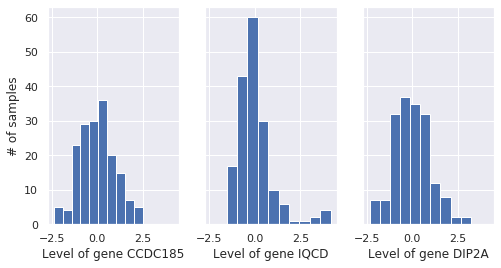

In [0]:
# histograms
sns.set()
gene1, gene2, gene3 = 100, 200, 300
fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(8,4))
data.iloc[:,gene1].plot.hist(ax=axes[0])
data.iloc[:,gene2].plot.hist(ax=axes[1])
data.iloc[:,gene3].plot.hist(ax=axes[2])
axes[0].set_xlabel('Level of gene ' + df.iloc[:,gene1].name)
axes[1].set_xlabel('Level of gene ' + df.iloc[:,gene2].name)
axes[2].set_xlabel('Level of gene ' + df.iloc[:,gene3].name)
axes[0].set_ylabel('# of samples')

The distribution of the samples appears to be (somewhat) normal for these few genes. Now that we have some idea of what the data looks like, we will begin classification.

## Gaussian Naive Bayes
Naive Bayes is arguably one of the simplest classification techniques in machine learning. There are no hyperparameters to tune, one simply needs to run the model. Here I use the Gaussian version of the algorithm, as the predictors are continuous not categorical. 

Let's test this method via 5-fold cross validation. I use the stratified version of train-test split, as not all the classes are equally represented.

In [0]:
# GNB, 5-fold cross validation.
random.seed(711)
gnb_mod = GaussianNB()   # Create a Gaussian Classifier
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5-fold
error = []
for train_index, test_index in skf.split(data, labels):
  X_train, X_test = data.iloc[train_index], data.iloc[test_index]  # train-test split
  y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
  gnb_mod.fit(X_train, y_train)    # fit on train
  y_pred = gnb_mod.predict(X_test)  # predict on test
  error.append(metrics.accuracy_score(y_test, y_pred))   # model accuracy
print(sum(error)/len(error))  # average accuracy


0.9680357142857143


96.8% prediction accuracy! This is impressive for a model that took no work to tune and a difficult data set.

## Random Forest
Random forest is an extremely popular out-of-the-box ML tool that works very well with very little tuning on a variety of datasets. It works by averaging a large number of high-variance decision trees. Here we will test RF with 500, 1000, and 2000 trees using 5-fold CV. 

In [0]:
# RF, 5-fold CV
random.seed(731)
num_trees = [500,1000,2000]  # hyperparameters to test
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5-fold
error = []
for param in num_trees:
  rf_mod = RandomForestClassifier(n_estimators=param)   # create RF model
  for train_index, test_index in skf.split(data, labels):
    X_train, X_test = data.iloc[train_index], data.iloc[test_index]  # train-test split
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
    rf_mod.fit(X_train, y_train)    # fit on train
    y_pred = rf_mod.predict(X_test)  # predict on test
    error.append(metrics.accuracy_score(y_test, y_pred))   # model accuracy
  print("Accuracy:",sum(error)/len(error), "with", param, "trees")  # average accuracy

Accuracy: 0.9766071428571429 with 500 trees
Accuracy: 0.9825892857142857 with 1000 trees
Accuracy: 0.9883928571428572 with 2000 trees


Our best model performed with 98.8% accuracy. This is an incredible performance on a model that also took very little tuning. RF models are often used a baseline for testing the performance of more complex models. 98.8% is a very high bar to beat! I will now attempt to beat this with other models, but if not, this accuracy is stellar performance given the data.

## Boosting
Tree boosting is a powerful method that combines many weak learners (small trees) succesively to create an aggregate model. Each model takes much longer to run and tune than the methods used above, as the model building process is computationally expensive and there are more hyperparameters. As an illustration I run a single boosting model with 5-fold CV using sci-kit learn's implementation.

In [0]:
# Boosting, 5-fold CV
random.seed(1699)
boost_mod = GradientBoostingClassifier(n_estimators=100,learning_rate=.1,max_depth=2)   # create boosting model
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5-fold
error = []
for train_index, test_index in skf.split(data, labels):
  X_train, X_test = data.iloc[train_index], data.iloc[test_index]  # train-test split
  y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
  boost_mod.fit(X_train, y_train)    # fit on train
  y_pred = boost_mod.predict(X_test)  # predict on test
  error.append(metrics.accuracy_score(y_test, y_pred))   # model accuracy
print(sum(error)/len(error))  # average accuracy

0.8578571428571429


As is evident, this model needs much more tuning in order to be able to perform well. I will now perform a grid search using a single train-test split.

In [0]:
# Boosting, Grid search
random.seed(711)
n_trees = np.array([50,100,500])  
rate = np.array([.001, .01, .1])
depth = np.array([2,4])
params = np.array(np.meshgrid(n_trees, rate, depth)).reshape(3,-1).T  # grid search parameters

X_train, X_test, y_train, y_test = train_test_split(data, labels, stratify=labels, test_size=0.2)  # single train-test split
error = []

# create boosting model for each combination of hyperparameters
for p in params:
  boost_mod = GradientBoostingClassifier(n_estimators=int(p[0]),learning_rate=p[1],max_depth=int(p[2]))
  boost_mod.fit(X_train, y_train)
  y_pred = boost_mod.predict(X_test)  # predict on test
  error.append(metrics.accuracy_score(y_test, y_pred))   # model accuracy
  print(p, error[-1])
print(error)

[5.e+01 1.e-03 2.e+00] 0.6857142857142857
[5.e+01 1.e-03 4.e+00] 0.6
[1.e+02 1.e-03 2.e+00] 0.9428571428571428
[1.e+02 1.e-03 4.e+00] 0.9428571428571428
[5.e+02 1.e-03 2.e+00] 0.9714285714285714
[5.e+02 1.e-03 4.e+00] 0.9714285714285714
[5.e+01 1.e-02 2.e+00] 0.9714285714285714
[5.e+01 1.e-02 4.e+00] 0.9714285714285714
[1.e+02 1.e-02 2.e+00] 0.9714285714285714
[1.e+02 1.e-02 4.e+00] 0.9714285714285714
[5.e+02 1.e-02 2.e+00] 0.9714285714285714
[5.e+02 1.e-02 4.e+00] 0.9714285714285714
[50.   0.1  2. ] 0.9714285714285714
[50.   0.1  4. ] 0.9714285714285714
[100.    0.1   2. ] 0.9714285714285714
[100.    0.1   4. ] 0.9714285714285714
[5.e+02 1.e-01 2.e+00] 0.9714285714285714
[5.e+02 1.e-01 4.e+00] 0.9714285714285714
[0.6857142857142857, 0.6, 0.9428571428571428, 0.9428571428571428, 0.9714285714285714, 0.9714285714285714, 0.9714285714285714, 0.9714285714285714, 0.9714285714285714, 0.9714285714285714, 0.9714285714285714, 0.9714285714285714, 0.9714285714285714, 0.9714285714285714, 0.971428571

This grid search ended up being unhelpful. Because of the single train-test split, most of the parameter combinations yeilded the same accuracy scores. Unfortunately, we will need to use 5-fold CV to more precicely evaluate the hyperparameters.

In [0]:
# Boosting, 5-fold CV, Grid search
random.seed(711)
n_trees = np.array([50,100,500])  
rate = np.array([.001, .01, .1])
depth = np.array([2,4])
params = np.array(np.meshgrid(n_trees, rate, depth)).reshape(3,-1).T  # grid search params

# 5-fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5-fold
for p in params:
  boost_mod = GradientBoostingClassifier(n_estimators=int(p[0]), learning_rate=p[1], max_depth=int(p[2]))  # create boosting model
  error = []
  for train_index, test_index in skf.split(data, labels):
    X_train, X_test = data.iloc[train_index], data.iloc[test_index]  # train-test split
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
    boost_mod.fit(X_train, y_train)    # fit on train
    y_pred = boost_mod.predict(X_test)  # predict on test
    error.append(metrics.accuracy_score(y_test, y_pred))   # model accuracy
  print(sum(error)/len(error), p)  # average accuracy

0.7244642857142857 [5.e+01 1.e-03 2.e+00]
0.7485714285714286 [5.e+01 1.e-03 4.e+00]
0.8132142857142857 [1.e+02 1.e-03 2.e+00]
0.8324999999999999 [1.e+02 1.e-03 4.e+00]
0.9244642857142857 [5.e+02 1.e-03 2.e+00]


KeyboardInterrupt: ignored

Here the run has been manually terminated after just 5 sets of hyperparameters have been tested. Even this took over 4 hours to run on my machine. This problem is quickly becoming intractable; Even with this very course grid, fitting 18 x 5 = 90 boosting models on 50,000 variables would take too long.

## Variable Selection
The time being taken is due to the 50,000+ variables that the model is trying to evaluate. In order to reduce the dimensionality and make this problem more tractable, we need to remove some of the variables.

The sklearn random forest implementation comes with a `feature_importances` attribute. It is determined by assessing the mean decrease in node impurity across the 100s of trees: variables that split the classes with greater purity are assigned a higher importance. We will use these importance scores to select which variables to use.

In [0]:
# RF variable importance
rf_mod = RandomForestClassifier(n_estimators=1000, random_state=3314)   # create RF model
_ = rf_mod.fit(data, labels)    # fit on entire dataset

Text(0.5, 1.0, 'Variable Importances')

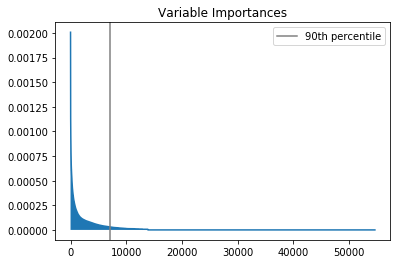

In [0]:
#@title 
var_import=np.sort(var_import)[::-1]
total, result = 0.0, 0
for i in range(len(var_import)):
  total = total + var_import[i]
  if total > .90:
    result = i
    break

plt.plot(np.arange(54623), var_import)
plt.fill_between(np.arange(54623),var_import)
line1= plt.axvline(x=result,color='gray')
plt.legend((line1,), ("90th percentile",))
plt.title("Variable Importances")

Above is shown the variable importance scores, sorted, for all 54,623 variables. As we can see, the vast majority of the variable importance is held within the top several thousand variables, with the vertical line indicating the 90th percentile mark.

Below I extract the 500, 1000, and 2000 most important features (as determined by the above score).

In [0]:
# extract most important features
var_import_index = np.argsort(rf_mod.feature_importances_)[::-1]   # sort by feature importance
data_best500 = data.iloc[:,var_import_index[:500]]   # top 500 features
data_best1000 = data.iloc[:,var_import_index[:1000]]    # top 1000
data_best2000 = data.iloc[:,var_import_index[:2000]]    # top 2000
print(data_best500.iloc[:5,:5])

               PAX8   TMEM101     RGS20    TRIM15     PRSS3
GSM803615 -0.385425  0.041156 -1.224200 -0.149815 -0.644826
GSM803674 -0.534277 -0.070203 -1.493759 -0.510926 -0.432550
GSM803733 -0.372903  0.010249 -0.781479 -0.638624 -0.517498
GSM803616 -0.674562  0.646346 -1.378388 -0.425276 -0.299458
GSM803675 -0.333305  0.490886 -1.156327  0.423250 -0.348551


A quick google of these genes is very encouraging. Acording to NCBI.gov: "Mutations in the PAX8 gene have been associated with thyroid dysgenesis, thyroid follicular carcinomas and atypical follicular thyroid adenomas." The top gene is associated with thyroid cancer! Below I plot the distributions of a few of these variables accross the 9 classes.

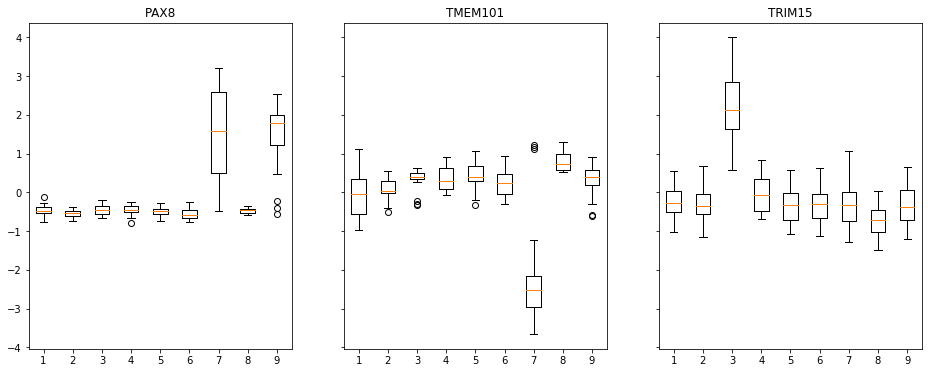

In [0]:
fig, axes = plt.subplots(ncols=3, sharey=True, figsize=(16,6),)
pax8_box = [data_best500[labels==i].iloc[:,0] for i in range(9)]
tmem101_box = [data_best500[labels==i].iloc[:,1] for i in range(9)]
trim15_box = [data_best500[labels==i].iloc[:,3] for i in range(9)]
_= axes[0].boxplot(pax8_box)
axes[0].set_title("PAX8")
_=axes[1].boxplot(tmem101_box)
axes[1].set_title("TMEM101")
_=axes[2].boxplot(trim15_box)
_=axes[2].set_title("TRIM15")

These variables with high importance are clearly very useful in separating the classes. PAX8 has high expression in classes 7 and 9, TMEM101 has low expression for class 7, and TRIM15 has high expression in class 3.

## Boosting with Variable Selection
Now I will attempt the same grid search as above, w/ 5 fold CV, using only the top 500 variables.

In [0]:
# Boosting 500 features, 5-fold CV, Grid search
random.seed(711)
n_trees = np.array([100, 500, 900])  # grid search parameters
rate = np.array([.1, .01, .001])
depth = np.array([2, 4])
params = np.array(np.meshgrid(n_trees, rate, depth)).reshape(3,-1).T

# 5-fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5-fold
for p in params:
  boost_mod = GradientBoostingClassifier(n_estimators=int(p[0]), learning_rate=p[1], max_depth=int(p[2]))  # create boosting model
  error = []
  for train_index, test_index in skf.split(data_best500, labels):
    X_train, X_test = data_best500.iloc[train_index], data_best500.iloc[test_index]  # train-test split
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
    boost_mod.fit(X_train, y_train)    # fit on train
    y_pred = boost_mod.predict(X_test)  # predict on test
    error.append(metrics.accuracy_score(y_test, y_pred))   # model accuracy
  print(sum(error)/len(error), p)  # average accuracy


0.9258928571428571 [100.    0.1   2. ]
0.9296428571428571 [100.    0.1   4. ]
0.9446428571428571 [5.e+02 1.e-01 2.e+00]
0.925357142857143 [5.e+02 1.e-01 4.e+00]
0.9473214285714284 [9.e+02 1.e-01 2.e+00]
0.9248214285714285 [9.e+02 1.e-01 4.e+00]
0.9225 [1.e+02 1.e-02 2.e+00]
0.9242857142857144 [1.e+02 1.e-02 4.e+00]
0.9473214285714284 [5.e+02 1.e-02 2.e+00]
0.9560714285714287 [5.e+02 1.e-02 4.e+00]
0.9217857142857143 [9.e+02 1.e-02 2.e+00]
0.9466071428571429 [9.e+02 1.e-02 4.e+00]
0.8448214285714286 [1.e+02 1.e-03 2.e+00]
0.8566071428571428 [1.e+02 1.e-03 4.e+00]
0.9473214285714284 [5.e+02 1.e-03 2.e+00]
0.9216071428571428 [5.e+02 1.e-03 4.e+00]
0.9226785714285715 [9.e+02 1.e-03 2.e+00]
0.9253571428571428 [9.e+02 1.e-03 4.e+00]


This code ran much faster, but these results are not encouraging. The top score was 94% accuracy, which doesn't even beat Naive Bayes. Perhaps 500 variables are not enough. We attempt the same with 1000 variables.

In [0]:
#@title Boosting, top 1000 features
# Boosting after feature selection, 5-fold CV, Grid search, best 1000
random.seed(711)
n_trees = np.array([100, 500, 900])  # grid search parameters
rate = np.array([.1, .01, .001])
depth = np.array([2, 4])
params = np.array(np.meshgrid(n_trees, rate, depth)).reshape(3,-1).T

# 5-fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5-fold
for p in params:
  boost_mod = GradientBoostingClassifier(n_estimators=int(p[0]), learning_rate=p[1], max_depth=int(p[2]))  # create boosting model
  error = []
  for train_index, test_index in skf.split(data_best1000, labels):
    X_train, X_test = data_best1000.iloc[train_index], data_best1000.iloc[test_index]  # train-test split
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
    boost_mod.fit(X_train, y_train)    # fit on train
    y_pred = boost_mod.predict(X_test)  # predict on test
    error.append(metrics.accuracy_score(y_test, y_pred))   # model accuracy
  print(sum(error)/len(error), p)  # average accuracy

0.9535714285714285 [100.    0.1   2. ]
0.9428571428571428 [100.    0.1   4. ]
0.9724999999999999 [5.e+02 1.e-01 2.e+00]
0.8914285714285715 [5.e+02 1.e-01 4.e+00]
0.98375 [9.e+02 1.e-01 2.e+00]
0.9446428571428571 [9.e+02 1.e-01 4.e+00]
0.9766071428571429 [1.e+02 1.e-02 2.e+00]
0.9351785714285714 [1.e+02 1.e-02 4.e+00]
0.9358928571428571 [5.e+02 1.e-02 2.e+00]
0.9221428571428572 [5.e+02 1.e-02 4.e+00]
0.9116071428571428 [9.e+02 1.e-02 2.e+00]
0.9419642857142858 [9.e+02 1.e-02 4.e+00]
0.8487500000000001 [1.e+02 1.e-03 2.e+00]
0.8491071428571428 [1.e+02 1.e-03 4.e+00]
0.9321428571428572 [5.e+02 1.e-03 2.e+00]
0.90625 [5.e+02 1.e-03 4.e+00]
0.9546428571428571 [9.e+02 1.e-03 2.e+00]
0.91375 [9.e+02 1.e-03 4.e+00]


This is better. The best model had 98.3% accuracy. It's parameters were `[n_estimators=900, learning_rate=.1, max_depth=2] `. This is getting close to our Random Forest benchmark of 98.8%.

I will now grid-search around these parameters: I will try `n_estimators=[800,1000,1200]` and `learning_rate=[.01,.1,.2]` with `max_depth=2` 

In [0]:
#@title Grid Search, top 1000 features
# Boosting after feature selection, 5-fold CV, Grid search, best 1000
random.seed(711)
n_trees = np.array([800, 1000, 1200])  # grid search parameters
rate = np.array([.05, .1, .2])
depth = np.array([2])
params = np.array(np.meshgrid(n_trees, rate, depth)).reshape(3,-1).T

# 5-fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5-fold
for p in params:
  boost_mod = GradientBoostingClassifier(n_estimators=int(p[0]), learning_rate=p[1], max_depth=int(p[2]))  # create boosting model
  error = []
  for train_index, test_index in skf.split(data_best, labels):
    X_train, X_test = data_best.iloc[train_index], data_best.iloc[test_index]  # train-test split
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
    boost_mod.fit(X_train, y_train)    # fit on train
    y_pred = boost_mod.predict(X_test)  # predict on test
    error.append(metrics.accuracy_score(y_test, y_pred))   # model accuracy
  print(sum(error)/len(error), p)  # average accuracy

0.9435714285714285 [8.e+02 5.e-02 2.e+00]
0.9580357142857142 [1.e+03 5.e-02 2.e+00]
0.9305357142857144 [1.2e+03 5.0e-02 2.0e+00]
0.9216071428571428 [8.e+02 1.e-01 2.e+00]
0.9378571428571428 [1.e+03 1.e-01 2.e+00]
0.9435714285714287 [1.2e+03 1.0e-01 2.0e+00]
0.9335714285714285 [8.e+02 2.e-01 2.e+00]
0.9428571428571428 [1.e+03 2.e-01 2.e+00]
0.9321428571428572 [1.2e+03 2.0e-01 2.0e+00]


None of these settings improved performance. I will retry the original search parameters, but with 2000 variables.

In [0]:
#@title Boosting, top 2000 features
# Boosting after feature selection, 5-fold CV, Grid search, best 2000
random.seed(711)
n_trees = np.array([100, 500, 900])  # grid search parameters
rate = np.array([.1, .01, .001])
depth = np.array([2, 4])
params = np.array(np.meshgrid(n_trees, rate, depth)).reshape(3,-1).T

# 5-fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5-fold
for p in params:
  boost_mod = GradientBoostingClassifier(n_estimators=int(p[0]), learning_rate=p[1], max_depth=int(p[2]))  # create boosting model
  error = []
  for train_index, test_index in skf.split(data_best2000, labels):
    X_train, X_test = data_best2000.iloc[train_index], data_best2000.iloc[test_index]  # train-test split
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
    boost_mod.fit(X_train, y_train)    # fit on train
    y_pred = boost_mod.predict(X_test)  # predict on test
    error.append(metrics.accuracy_score(y_test, y_pred))   # model accuracy
  print(sum(error)/len(error), p)  # average accuracy

0.9730357142857142 [100.    0.1   2. ]
0.9135714285714286 [100.    0.1   4. ]
0.8982142857142857 [5.e+02 1.e-01 2.e+00]
0.95625 [5.e+02 1.e-01 4.e+00]
0.9394642857142858 [9.e+02 1.e-01 2.e+00]
0.9446428571428571 [9.e+02 1.e-01 4.e+00]
0.9166071428571427 [1.e+02 1.e-02 2.e+00]
0.9151785714285714 [1.e+02 1.e-02 4.e+00]
0.9605357142857143 [5.e+02 1.e-02 2.e+00]
0.9319642857142856 [5.e+02 1.e-02 4.e+00]
0.9596428571428571 [9.e+02 1.e-02 2.e+00]
0.9396428571428572 [9.e+02 1.e-02 4.e+00]
0.8701785714285715 [1.e+02 1.e-03 2.e+00]
0.8753571428571428 [1.e+02 1.e-03 4.e+00]
0.9435714285714287 [5.e+02 1.e-03 2.e+00]
0.90625 [5.e+02 1.e-03 4.e+00]
0.91875 [9.e+02 1.e-03 2.e+00]
0.918392857142857 [9.e+02 1.e-03 4.e+00]


None of these models outperformed the models with only 1000 features, and this is beggining to take significantly more time to run. We will try to optimize the approach.

## XGBoost
XGBoost is the python industry standard for boosted trees, with several useful features including stochastic gradient boosting and GPU acceleration. This will allow me to run models faster.

Another important method used often in practice is Random Search (as opposed to Grid Search). It is more thoughrough, and can efficiently explore more of the parameter space.


<img src="https://drive.google.com/uc?id=1WIqueGgaqcXRMWBcljgrMd10IBnluKQN"  width= "700"> 


*With grid search, nine trials only test three distinct places in the important parameter. With random search, all nine trails explore distinct values. Figure Credit: Peter Worcester*

I will attempt a RandomSearch through the parameters, and will attempt to use the stochastic boosting feature. This means that only a random portion of the variables and datapoints are used to fit each small tree. For this trial I will use 10% of the rows and 10% of the columns for stochastic boosting. This will allow the models to run in reasonable time.

In [0]:
#XGboost, RandomSearch, stochastic gradient
random.seed(711)
n_iter = 10

n_trees = np.array([100, 200, 300, 500, 700])  
rate = np.array([0.1, .07, .05, .03, 0.01])
depth = np.array([2,3,4])
params = np.array([np.random.choice(n_trees,n_iter),np.random.choice(rate,n_iter),np.random.choice(depth,n_iter)]).T  # grid search params

# 5-fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5-fold
for p in params:
  boost_mod = XGBClassifier(n_estimators=int(p[0]), learning_rate=p[1], max_depth=int(p[2]), colsample_bytree=.1, subsample=.1, tree_method="gpu_hist")   # create boosting model
  error = []
  for train_index, test_index in skf.split(data, labels):
    X_train, X_test = data.iloc[train_index].to_numpy(), data.iloc[test_index].to_numpy()  # train-test split
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
    boost_mod.fit(X_train, y_train)    # fit on train
    y_pred = boost_mod.predict(X_test)  # predict on test
    error.append(metrics.accuracy_score(y_test, y_pred))   # model accuracy
  print(sum(error)/len(error), p)  # average accuracy

0.8680357142857144 [3.e+02 1.e-02 4.e+00]
0.9125 [5.e+02 5.e-02 2.e+00]
0.9333928571428572 [7.e+02 5.e-02 3.e+00]
0.9141071428571429 [7.e+02 3.e-02 3.e+00]
0.9308928571428572 [7.e+02 7.e-02 4.e+00]
0.6789285714285714 [1.e+02 1.e-02 4.e+00]
0.8955357142857142 [5.e+02 3.e-02 4.e+00]
0.8532142857142857 [2.e+02 7.e-02 4.e+00]
0.8144642857142858 [2.e+02 1.e-02 4.e+00]
0.7126785714285714 [1.e+02 5.e-02 2.e+00]


My initial trial is not too promising with a best score of 93%, but I will try again without stochastic boosting (100% of rows and cols used). In order to speed things up, I will use only the top 500 features selected previously. 

In [0]:
#@title XGBoost, RandomSearch, top 500 features
#Boosting, Random grid search, XGboost, feature selection

random.seed(711)
# create a default XGBoost classifier
boost_mod = XGBClassifier(tree_method="gpu_hist") 
# create K-fold object
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5-fold
# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "learning_rate": [0.1, .07, .05, .03, 0.01],
    "max_depth": [2, 3, 4],
    "n_estimators": [100, 200, 300, 500, 700],
}
# create the grid search object
grid = RandomizedSearchCV(estimator=boost_mod, param_distributions=param_grid,cv=skf,scoring='accuracy',n_jobs=-1,n_iter=10)
# fit grid search
best_model = grid.fit(data_best500.to_numpy(), labels)

print(f'Best score: {best_model.best_score_}')
print(f'Best model: {best_model.best_params_}')

In [0]:
pd.DataFrame(best_model.cv_results_).iloc[:,[4,5,6,-3]]

,param_n_estimators,param_max_depth,param_learning_rate,mean_test_score
0,500,3,0.05,0.936782
1,700,4,0.07,0.931034
2,700,3,0.05,0.936782
3,300,2,0.03,0.942529
4,300,4,0.05,0.936782
5,200,3,0.07,0.931034
6,200,4,0.01,0.885057
7,300,3,0.1,0.936782
8,700,4,0.1,0.936782
9,700,2,0.07,0.942529


Results are slightly better, with a top score of 94%. I will repeat the above search with the top 1000 and 2000 features.

In [0]:
#@title XGBoost, RandomSearch, top 1000 features
#Boosting, Random grid search, XGboost, best 1000 features

random.seed(711)
# create a default XGBoost classifier
boost_mod = XGBClassifier(tree_method="gpu_hist") 

# create K-fold object
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5-fold
# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "learning_rate": [0.1, .07, .05, .03, 0.01],
    "max_depth": [2, 3, 4],
    "n_estimators": [100, 200, 300, 500, 700],
}
scoring = 'accuracy'

# create the grid search object
grid = RandomizedSearchCV(
    estimator=boost_mod, 
    param_distributions=param_grid,
    cv=skf,
    scoring=scoring,
    n_jobs=-1,
    n_iter=10,
)
# fit grid search
best_model = grid.fit(data_best1000.to_numpy(), labels)

print(f'Best score: {best_model.best_score_}')
print(f'Best model: {best_model.best_params_}')

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best score: 0.9712643678160919
Best model: {'n_estimators': 700, 'max_depth': 4, 'learning_rate': 0.05}


In [0]:
#@title XGBoost, RandomSearch, top 2000 features
#Boosting, Random grid search, XGboost, best 2000 feature selection

random.seed(711)
# create a default XGBoost classifier
boost_mod = XGBClassifier(tree_method="gpu_hist") 
# create K-fold object
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5-fold
# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "learning_rate": [0.1, .07, .05, .03, 0.01],
    "max_depth": [2, 3, 4],
    "n_estimators": [100, 200, 300, 500, 700],
}
scoring = 'accuracy'

# create the grid search object
grid = RandomizedSearchCV(
    estimator=boost_mod,param_distributions=param_grid,cv=skf,scoring=scoring,n_jobs=-1,n_iter=10)
# fit grid search
best_model = grid.fit(data_best2000.to_numpy(), labels)

print(f'Best score: {best_model.best_score_}')
print(f'Best model: {best_model.best_params_}')

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best score: 0.9827586206896551
Best model: {'n_estimators': 700, 'max_depth': 3, 'learning_rate': 0.03}


This is much better. With 1000 variables, 97.1% was acheived, and with 2000, 98.2%. I will using these parameters with all the features:

In [0]:
# XGBoost, 5-fold CV, all features used
random.seed(1699)
boost_mod = XGBClassifier(n_estimators=700,learning_rate=.05,max_depth=4, tree_method="gpu_hist")   # create boosting model
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5-fold
error = []
for train_index, test_index in skf.split(data, labels):
  X_train, X_test = data.iloc[train_index].to_numpy(), data.iloc[test_index].to_numpy()  # train-test split
  y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
  boost_mod.fit(X_train, y_train)    # fit on train
  y_pred = boost_mod.predict(X_test)  # predict on test
  error.append(metrics.accuracy_score(y_test, y_pred))   # model accuracy
print(sum(error)/len(error))  # average accuracy

0.9198214285714286


Adding in the rest of the features did not help, and in fact detracted quite a bit, likely due to higher variance. I notice that higher numbers of trees seem to perform well (700 trees, at the upper end of the search). I now a search with higher numbers of trees, between 600 and 1200. 

In [0]:
# Another grid search, more trees.
#XGBoost, RandomSearch, top 2000 features

random.seed(711)
# create a default XGBoost classifier
boost_mod = XGBClassifier(tree_method="gpu_hist") 
# create K-fold object
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5-fold
# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "learning_rate": stats.uniform(loc=.01,scale=.99),
    "max_depth": [2, 4],
    "n_estimators": np.arange(600,1200),
}

# create the grid search object
grid = RandomizedSearchCV(estimator=boost_mod, param_distributions=param_grid, cv=skf, scoring='accuracy', n_jobs=-1, n_iter=10)
# fit grid search
best_model = grid.fit(data_best2000.to_numpy(), labels)

print(f'Best score: {best_model.best_score_}')
print(f'Best model: {best_model.best_params_}')

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best score: 0.9827586206896551
Best model: {'learning_rate': 0.5255287278569792, 'max_depth': 2, 'n_estimators': 970}


Again, good, but no improvement over the previous. We still have not beaten random forest at 98.8%

Now comes a twist in my tale: by chance I ran a model with the following parameters, using some mild stochastic boosting.

In [0]:
# XGBoost, 5-fold CV, all features
random.seed(1699)
boost_mod = XGBClassifier(n_estimators=100,learning_rate=.1,max_depth=2, tree_method="gpu_hist", colsample_bytree=.7, subsample=.7)   # create boosting model
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5-fold
error = []
for train_index, test_index in skf.split(data, labels):
  X_train, X_test = data.iloc[train_index].to_numpy(), data.iloc[test_index].to_numpy()  # train-test split
  y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
  boost_mod.fit(X_train, y_train)    # fit on train
  y_pred = boost_mod.predict(X_test)  # predict on test
  error.append(metrics.accuracy_score(y_test, y_pred))   # model accuracy
print(sum(error)/len(error))  # average accuracy

0.9875


This is the highest score yet! I now do a RandomSearch around those parameters:

In [0]:
# random search around the lucky numbers
# XGBoost, all features
random.seed(711)
n_iter = 10 # n random searches

# search parameters
n_trees = np.arange(70,130) 
rate = np.linspace(.05,.5,50)
cols_samp = np.linspace(.5,1,50)
subsamp = np.linspace(.3,1,50)
params = np.array([np.random.choice(n_trees,n_iter),np.random.choice(rate,n_iter),np.random.choice(cols_samp,n_iter),np.random.choice(subsamp,n_iter)]).T

# 5-fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5-fold
for p in params:
  boost_mod = XGBClassifier(n_estimators=int(p[0]), learning_rate=p[1], max_depth=2, colsample_bytree=p[2], subsample=p[3], tree_method="gpu_hist")   # create boosting model
  error = []
  for train_index, test_index in skf.split(data, labels):
    X_train, X_test = data.iloc[train_index].to_numpy(), data.iloc[test_index].to_numpy()  # train-test split
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
    boost_mod.fit(X_train, y_train)    # fit on train
    y_pred = boost_mod.predict(X_test)  # predict on test
    error.append(metrics.accuracy_score(y_test, y_pred))   # model accuracy
  print("Accuracy:",sum(error)/len(error),"params:", p)  # average accuracy

Accuracy: 0.9875 params: [105.       0.2337   0.7755   0.6143]
Accuracy: 0.9830357142857142 params: [126.       0.4449   0.5408   0.7429]
Accuracy: 0.9698214285714286 params: [87.      0.3622  0.7551  0.4429]
Accuracy: 0.9824999999999999 params: [9.0000e+01 6.8367e-02 6.8367e-01 6.7143e-01]
Accuracy: 0.9603571428571428 params: [87.      0.1235  0.949   0.8714]
Accuracy: 0.9583928571428573 params: [125.       0.5      0.5      0.5714]
Accuracy: 0.9823214285714286 params: [109.       0.3806   0.8061   0.4714]
Accuracy: 0.9885714285714287 params: [98.      0.1418  0.8673  0.7714]
Accuracy: 0.9817857142857143 params: [1.2000e+02 1.0510e-01 9.3878e-01 9.0000e-01]
Accuracy: 1.0 params: [74.      0.2429  0.6939  0.5857]


100% accuracy with 5-fold CV! To veryfy I repeat with those parameters and a different seed:

In [0]:
# Boosting, 5-fold CV, XGBoost
random.seed(7211)
boost_mod = XGBClassifier(n_estimators=74,learning_rate=.2429,max_depth=2, tree_method="gpu_hist", colsample_bytree=.6939, subsample=.5857)   # create boosting model
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5-fold
error = []
for train_index, test_index in skf.split(data, labels):
  X_train, X_test = data.iloc[train_index].to_numpy(), data.iloc[test_index].to_numpy()  # train-test split
  y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
  boost_mod.fit(X_train, y_train)    # fit on train
  y_pred = boost_mod.predict(X_test)  # predict on test
  error.append(metrics.accuracy_score(y_test, y_pred))   # model accuracy
print(sum(error)/len(error))  # average accuracy

0.9942857142857143


Incredible! Boosting (with a lot of tuning) was able to beat random forest by a small margin.

Below is a simple summary of the best reult for each type of model.

In [0]:
# Results Summary
print("Model:\t\t\t", "Accuracy:")
print("Naive Bayes\t\t\t96.8%")
print("Random Forest\t\t\t98.8%")
print("Boosting\t\t\t92.3%")
print("Boosting, var selection\t\t98.4%")
print("Boosting, stochastic\t\t99.4%")

Model:			 Accuracy:
Naive Bayes			96.8%
Random Forest			98.8%
Boosting			92.3%
Boosting, var selection		98.4%
Boosting, stochastic		99.4%


## Conclusion
From a biological standpoint, the most useful part of this study is the variable importance: finding out which genes are most important in which types of cancer. Even then, it would have been more useful to compare cancerous cells of one type to non-cancerous cells of the same type. As it stands, it is unclear whether important genes are unique to the cancer type, or simply to the cell type (eg. genes unique to the brain vs genes unique to the liver). But that was not the goal of this model: oncogene identification is another thing entirely. 

From a data science standpoint, These models did unexpectedly well for relatively low sample size and high dimensionality, with a large number of classes. Random Forest performed incredibly well with almost no tuning. Boosting took and incredible ammount of tuning to outperform RF, but eventually did beat RF by a bit. Interestigly, feature selection ended up not being used in the final model. 

